This code compares the HyMoLAP and LSTM models performance for multi-day ahead streamflow simulation in the Bonou sub-catchment.

In [611]:
# Librairies
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate

import math

from scipy.stats import norm

import joblib
import matplotlib.dates as mdates
from google.colab import files

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import json

In [612]:
import random
import os

# Set seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If you are using CUDA
np.random.seed(SEED)
random.seed(SEED)

In [613]:
#NSE, RMSE, KGE
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def kge(obs, sim):
    """ Kling-Gupta Efficiency (KGE)"""
    obs, sim = np.array(obs), np.array(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    beta = np.mean(sim) / np.mean(obs)
    gamma = (np.std(sim) / np.mean(sim)) / (np.std(obs) / np.mean(obs))

    return 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)


In [614]:
# Import data
from google.colab import drive
drive.mount('/content/drive')

daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Bonou/calage_biao.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [615]:
daily.head()

,debit,pluie,etp
0,23.120001,0.6252,3.142820
1,22.760000,0.0000,2.982918
2,22.180000,0.0000,3.682083
3,21.590000,0.0000,3.758521
4,20.990000,0.0000,3.551428


# HyMoLAP Model

In [616]:
#Calibration data
discharge = daily.iloc[:1461, 0].to_numpy()
prec = daily.iloc[:1461, 1].to_numpy()
pet = daily.iloc[:1461, 2].to_numpy()

In [617]:
#X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

In [618]:
#Estimates of the HyMoLAP
MU = 0.8001196845564451
LAMBDA = 8.242717863862458

Multi-step prediction

VALIDATION

In [619]:
# Validation data
discharge1 = daily.iloc[1461:, 0].to_numpy()
prec1 = daily.iloc[1461:, 1].to_numpy()
pet1 = daily.iloc[1461:, 2].to_numpy()

#Compute the Effective precipitation
prec_eff1 = prec1 - pet1
prec_eff1[prec_eff1 < 0] = 0

#X(t)
X = state_basin(MU, LAMBDA, prec_eff1)

1-day ahead

In [620]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)

    return Q_next

S711 = np.zeros(len(discharge1)) #Vector for stocking the prediction
S711[0] = discharge1[0]

for k in range(0, len(discharge1)-1, 1):
    S711[k + 1] = compute_Q(discharge1[k], X[k] * prec_eff1[k], MU, LAMBDA)


In [621]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S711[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S711[1:]))

print('kge=',kge(discharge1[1:], S711[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.9966141715736393
rmse= 12.567122210618226
kge= 0.9975020866072433


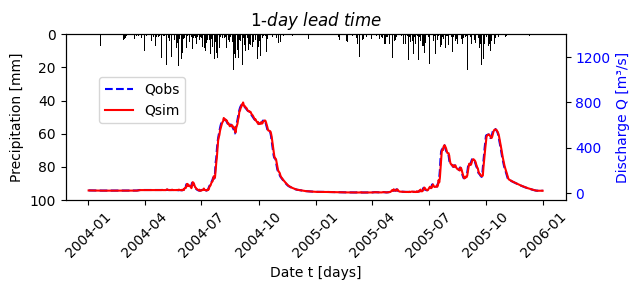

In [622]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S711[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$1$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


3-day ahead

In [623]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 4):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S713 = np.zeros(len(discharge1))
S713[0] = discharge1[0]

for k in range(0, len(discharge1)-2, 3):  #loup
    (S713[k+1], S713[k+2], S713[k+3]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [624]:
#We check here the last value reached by the loup
S713[-2], S713[-1]

(21.030641883385012, 0.0)

In [625]:
#We compute  streamflow for last days that were not considered in the loup
psi = X[-2]*prec_eff1[-2]
S713[-1] = discharge1[-2] +  (- (MU / LAMBDA) * discharge1[-2]**(2 * MU - 1) + (1 / LAMBDA) * psi)

In [626]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S713[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S713[1:]))

print('kge=',kge(discharge1[1:], S713[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.9858373956692847
rmse= 25.702473858281124
kge= 0.9911441481312079


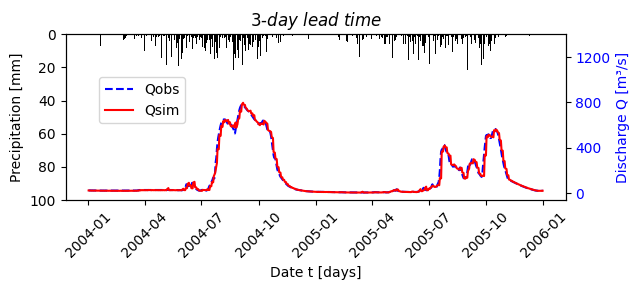

In [627]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S713[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$3$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


7-day ahead

In [628]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 8):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S717 = np.zeros(len(discharge1))
S717[0] = discharge1[0]

for k in range(0, len(discharge1)-3, 7):
    (S717[k+1], S717[k+2], S717[k+3], S717[k+4], S717[k+5], S717[k+6], S717[k+7]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [629]:
S717[-3], S717[-2]

(18.484830349154873, 0.0)

In [630]:
psi = X[-3]*prec_eff1[-3]
S717[-2] = discharge1[-3] +  (- (MU / LAMBDA) * discharge1[-3]**(2 * MU - 1) + (1 / LAMBDA) * psi)

S717[-1] = 2*S717[-2] - S717[-3]

In [631]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S717[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S717[1:]))

print('kge=',kge(discharge1[1:], S717[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.9548429667739058
rmse= 45.895073081653564
kge= 0.9766946404874096


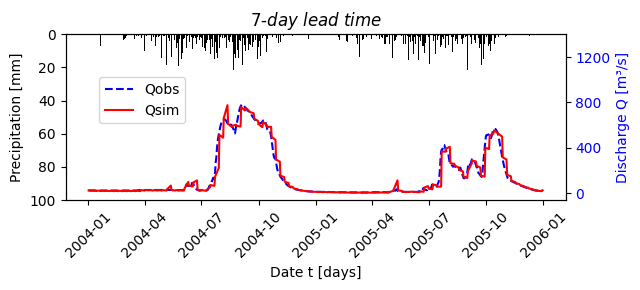

In [632]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S717[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


10-day ahead

In [633]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 11):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S7110 = np.zeros(len(discharge1))
S7110[0] = discharge1[0]

for k in range(0, len(discharge1)-1, 10):
    (S7110[k+1], S7110[k+2], S7110[k+3], S7110[k+4], S7110[k+5], S7110[k+6], S7110[k+7],
     S7110[k+8], S7110[k+9], S7110[k+10]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [634]:
S7110[-1]

16.575471698482268

In [635]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S7110[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S7110[1:]))

print('kge=',kge(discharge1[1:], S7110[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.9209378641031676
rmse= 60.72781234777631
kge= 0.958973857898287


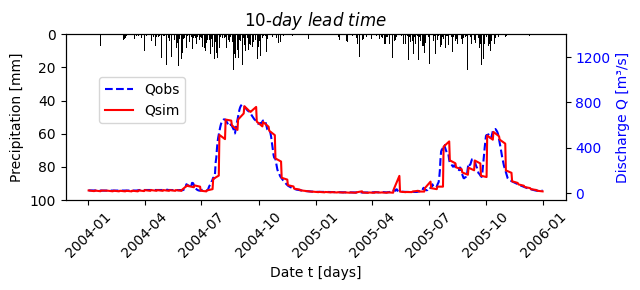

In [636]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S7110[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$10$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


# ..........................

## LSTM Model

In [637]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=80, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        lstm_out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(lstm_out[:, -1, :])  # Last output from the LSTM
        return out

# Model parameters
input_size = 1   # Number of input variables
hidden_size = 80  # Hidden layer size
num_layers = 2   # Number of LSTM layers
output_size = 1  # Number of time steps predicted

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Creating dataset

In [638]:
# Creating the DataFrame for training (calibration)
data_train = pd.DataFrame({
        'discharge': discharge[:-1],
         #'prec': prec[:-1],
         #'pet': pet[:-1],
        'target': discharge[1:]
})

# Creating the DataFrame for validation (test)
data_test = pd.DataFrame({
        'discharge': discharge1[:-1],
         #'prec': prec1[:-1],
         #'pet': pet1[:-1],
        'target': discharge1[1:]
})


# Splitting features and target
train_X, train_y = data_train.iloc[:, :-1].to_numpy(dtype=np.float32), data_train.iloc[:, -1].to_numpy(dtype=np.float32)
test_X, test_y = data_test.iloc[:, :-1].to_numpy(dtype=np.float32), data_test.iloc[:, -1].to_numpy(dtype=np.float32)

# Normalizing features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_train_X = scaler_X.fit_transform(train_X)
scaled_test_X = scaler_X.transform(test_X)  # Use transform() for test

# Normalizing the target
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_train_y = scaler_y.fit_transform(train_y.reshape(-1, 1)).flatten()
scaled_test_y = scaler_y.transform(test_y.reshape(-1, 1)).flatten()

Training

In [639]:
# Converting data to PyTorch tensors
scaled_train_X = torch.tensor(scaled_train_X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, input_size)
scaled_train_y = torch.tensor(scaled_train_y, dtype=torch.float32).unsqueeze(-1)  # (batch, output_size)

# Training parameters
epochs = 300

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Prediction
    y_pred = model(scaled_train_X)

    # Loss computation (adjusting y format)
    loss = criterion(y_pred, scaled_train_y)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Displaying loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 0.0863
Epoch 10, Loss: 0.0768
Epoch 20, Loss: 0.0732
Epoch 30, Loss: 0.0680
Epoch 40, Loss: 0.0595
Epoch 50, Loss: 0.0456
Epoch 60, Loss: 0.0260
Epoch 70, Loss: 0.0064
Epoch 80, Loss: 0.0005
Epoch 90, Loss: 0.0014
Epoch 100, Loss: 0.0003
Epoch 110, Loss: 0.0004
Epoch 120, Loss: 0.0003
Epoch 130, Loss: 0.0003
Epoch 140, Loss: 0.0003
Epoch 150, Loss: 0.0003
Epoch 160, Loss: 0.0003
Epoch 170, Loss: 0.0003
Epoch 180, Loss: 0.0003
Epoch 190, Loss: 0.0003
Epoch 200, Loss: 0.0003
Epoch 210, Loss: 0.0003
Epoch 220, Loss: 0.0002
Epoch 230, Loss: 0.0002
Epoch 240, Loss: 0.0002
Epoch 250, Loss: 0.0002
Epoch 260, Loss: 0.0002
Epoch 270, Loss: 0.0002
Epoch 280, Loss: 0.0002
Epoch 290, Loss: 0.0002


# Training Evaluation

In [640]:
#Evaluation mode
model.eval()

LSTMModel(
  (lstm): LSTM(1, 80, num_layers=2, batch_first=True)
  (fc): Linear(in_features=80, out_features=1, bias=True)
)

In [641]:
# Store predictions
predictions = []

# Predict 1-day ahead
for i in range(len(scaled_train_X)):
    input_seq = scaled_train_X[i].reshape(1, 1, -1)  # Ensures (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to PyTorch tensor

    pred = model(input_seq)  # Prediction
    predictions.append(pred.item())  # Convert to scalar and store

# print("Predictions:", predictions)

<ipython-input-641-5e4a18f437f1>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to PyTorch tensor


In [642]:
# Function to inverse transform the scaled target values back to their original scale
def inverse_transform(y):
    return scaler_y.inverse_transform(y.reshape(-1, 1))

In [643]:
# Inverse transform the predictions to their original scale
predictions_array = np.array(predictions).reshape(-1, 1)  # Convert to a 2D array
original_predictions = scaler_y.inverse_transform(predictions_array).flatten()

In [644]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge[1:], original_predictions)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], original_predictions))

print('kge=',kge(discharge[1:], original_predictions))

Nash-Sutcliffe Efficiency (NSE): 0.9970633620397927
rmse= 14.61491015804758
kge= 0.9976327991396068


# Validation: 1-day ahead Prediction

In [645]:
# Store the predictions
predictions1 = []

# Predict 1-day ahead for each day in the test set
for i in range(len(scaled_test_X)):
    input_seq = scaled_test_X[i].reshape(1, 1, -1)  # Ensure shape (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to PyTorch tensor

    pred1 = model(input_seq)  # Prediction
    predictions1.append(pred1.item())  # Convert to scalar and store

In [646]:
#Invert prevision
predictions_array1 = np.array(predictions1).reshape(-1, 1)
original_predictions1 = scaler_y.inverse_transform(predictions_array1).flatten()

In [647]:
# Performance evaluation
nse_value = nash_sutcliffe_efficiency(discharge1[1:], original_predictions1)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], original_predictions1))

print('kge=',kge(discharge1[1:], original_predictions1))

Nash-Sutcliffe Efficiency (NSE): 0.9959194851158393
rmse= 13.79624341242152
kge= 0.9920868457339297


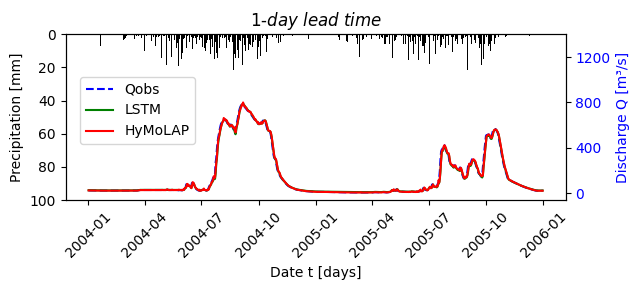

In [648]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, original_predictions1, 'g', label='LSTM')
ax2.plot(time, S711[1:], 'r', label='HyMoLAP')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$1$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


# Multi-step Prediction

In [649]:
def multi_step_forecast(model, input_seq, steps):
    """
    Multi-step ahead prediction in a loop
    :param model: Trained model (e.g., LSTM)
    :param input_seq: Initial sequence (torch tensor with shape (1, 1, input_size))
    :param steps: Number of days to predict
    :return: List of multi-step predictions
    """
    model.eval()
    predictions = []
    current_input = input_seq.clone()  # Copy to avoid modifying the original input

    for _ in range(steps):
        pred = model(current_input)  # Model prediction
        predictions.append(pred.item())  # Store the prediction

        # Update the input with the current prediction
        pred = pred.reshape(1, 1, 1)  # Ensure shape (batch=1, seq_length=1, input_size=1)
        current_input = pred  # Replace input with the prediction

    return predictions

3-day ahead

In [650]:
n_step = 3  # Number of time steps to predict

predictions_multi = []  # List to store all predictions

# Iterate over scaled_test_X, taking indices that are multiples of n_step
i = 0
while i < len(scaled_test_X):
    input_seq = scaled_test_X[i].reshape(1, 1, -1)  # Ensure shape (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to tensor

    pred_steps = multi_step_forecast(model, input_seq, steps=n_step)  # Multi-step prediction
    predictions_multi.extend(pred_steps)  # Add to the global list

    i += n_step  # Move forward by n_step

# Adjust the final size if it exceeds len(scaled_test_X)
if len(predictions_multi) > len(scaled_test_X):
    predictions_multi = predictions_multi[:len(scaled_test_X)]

# Check if the prediction fully covers the test series
print(f"Test series length: {len(scaled_test_X)}")
print(f"Predictions length: {len(predictions_multi)}")
#print(predictions_multi)  # List of predictions

Test series length: 730
Predictions length: 730


In [651]:
#Invert prevision
predictions_multi_array3 = np.array(predictions_multi).reshape(-1, 1)
original_predictions_multi_array3 = scaler_y.inverse_transform(predictions_multi_array3).flatten()

In [652]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], original_predictions_multi_array3)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], original_predictions_multi_array3))

print('kge=',kge(discharge1[1:], original_predictions_multi_array3))

Nash-Sutcliffe Efficiency (NSE): 0.9830648887727612
rmse= 28.10589320385188
kge= 0.9830456717776767


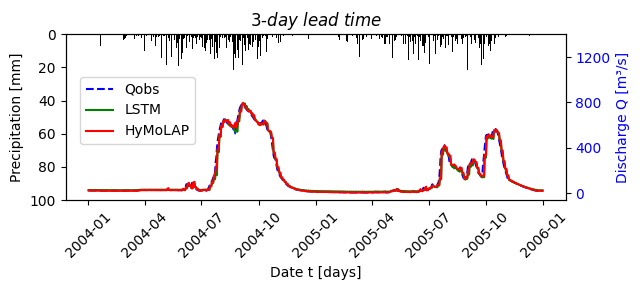

In [653]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, original_predictions_multi_array3, 'g', label='LSTM')
ax2.plot(time, S713[1:], 'r', label='HyMoLAP')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$3$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


7-day ahead

In [654]:
n_step = 7  # Number of time steps to predict

predictions_multi = []  # List to store all predictions

# Iterate over scaled_test_X, taking indices that are multiples of n_step
i = 0
while i < len(scaled_test_X):
    input_seq = scaled_test_X[i].reshape(1, 1, -1)  # Ensure shape (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to tensor

    pred_steps = multi_step_forecast(model, input_seq, steps=n_step)  # Multi-step prediction
    predictions_multi.extend(pred_steps)  # Add to the global list

    i += n_step  # Move forward by n_step

# Adjust the final size if it exceeds len(scaled_test_X)
if len(predictions_multi) > len(scaled_test_X):
    predictions_multi = predictions_multi[:len(scaled_test_X)]

# Check if the prediction fully covers the test series
print(f"Test series length: {len(scaled_test_X)}")
print(f"Predictions length: {len(predictions_multi)}")
#print(predictions_multi)  # List of predictions

Test series length: 730
Predictions length: 730


In [655]:
#Invert prevision
predictions_multi_array7 = np.array(predictions_multi).reshape(-1, 1)
original_predictions_multi_array7 = scaler_y.inverse_transform(predictions_multi_array7).flatten()

In [656]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], original_predictions_multi_array7)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], original_predictions_multi_array7))

print('kge=',kge(discharge1[1:], original_predictions_multi_array7))

Nash-Sutcliffe Efficiency (NSE): 0.9462559467482625
rmse= 50.06896032484159
kge= 0.9610538085427087


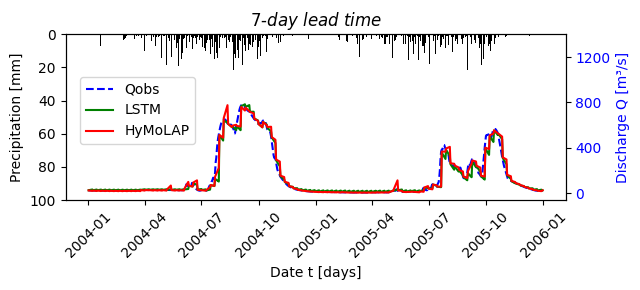

In [657]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the mean of the trajectories
ax2.plot(time, original_predictions_multi_array7, 'g', label='LSTM')
ax2.plot(time, S717[1:], 'r', label='HyMoLAP')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


10-day ahead

In [658]:
n_step = 10  # Number of time steps to predict

predictions_multi = []  # List to store all predictions

# Iterate over scaled_test_X, taking indices that are multiples of n_step
i = 0
while i < len(scaled_test_X):
    input_seq = scaled_test_X[i].reshape(1, 1, -1)  # Ensure shape (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to tensor

    pred_steps = multi_step_forecast(model, input_seq, steps=n_step)  # Multi-step prediction
    predictions_multi.extend(pred_steps)  # Add to the global list

    i += n_step  # Move forward by n_step

# Adjust the final size if it exceeds len(scaled_test_X)
if len(predictions_multi) > len(scaled_test_X):
    predictions_multi = predictions_multi[:len(scaled_test_X)]

# Check if the prediction fully covers the test series
print(f"Test series length: {len(scaled_test_X)}")
print(f"Predictions length: {len(predictions_multi)}")
#print(predictions_multi)  # List of predictions

Test series length: 730
Predictions length: 730


In [659]:
#Invert prevision
predictions_multi_array10 = np.array(predictions_multi).reshape(-1, 1)
original_predictions_multi_array10 = scaler_y.inverse_transform(predictions_multi_array10).flatten()

In [660]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], original_predictions_multi_array10)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], original_predictions_multi_array10))

print('kge=',kge(discharge1[1:], original_predictions_multi_array10))

Nash-Sutcliffe Efficiency (NSE): 0.9149971816024951
rmse= 62.96801862450735
kge= 0.9459302553172786


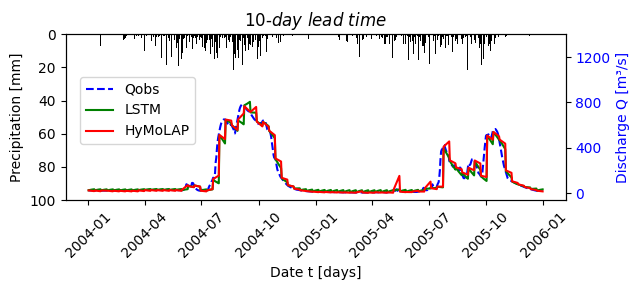

In [661]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, original_predictions_multi_array10, 'g', label='LSTM')
ax2.plot(time, S7110[1:], 'r', label='HyMoLAP')


# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$10$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()


# Display the plot
plt.show()
